In [1]:
!pip install gdown transformers underthesea rank_bm25 sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 51.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 13.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00


In [2]:
!gdown https://drive.google.com/uc?id=1JNfK2pul14ujIKYfpNECKfi2KkAjg8ZP

Downloading...
From: https://drive.google.com/uc?id=1JNfK2pul14ujIKYfpNECKfi2KkAjg8ZP
To: /kaggle/working/retriever_dataset.json
100%|███████████████████████████████████████| 6.34M/6.34M [00:00<00:00, 138MB/s]


In [3]:
import json as js
from transformers import AutoTokenizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from underthesea import word_tokenize
import re
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer
import torch

In [4]:
with open('/kaggle/working/retriever_dataset.json', 'r') as f:
    dataset = js.load(f)

print(js.dumps(dataset[0], indent=4, ensure_ascii=False))
print(len(dataset))

{
    "link": "https://thuvienphapluat.vn/hoi-dap-phap-luat/839C3F0-hd-nhung-doi-tuong-nao-duoc-vay-von-mua-may-tinh-thiet-bi-phuc-vu-hoc-tap-truc-tuyen.html",
    "question": "Những đối tượng nào được vay vốn mua máy tính, thiết bị phục vụ học tập trực tuyến?",
    "documents": [
        {
            "name": "Căn cứ tại Điều 3 Quyết định 09/2022/QĐ-TTg có quy định về đối tượng và điều kiện vay vốn như sau:",
            "law": "Đối tượng và điều kiện vay vốn\n1. Đối tượng vay vốn bao gồm:\na) Học sinh các cấp đang theo học tại các cơ sở giáo dục thuộc hệ thống giáo dục quốc dân theo quy định của Luật Giáo dục đáp ứng các điều kiện tại khoản 2 Điều này (sau đây gọi chung là học sinh);\nb) Học sinh, sinh viên đang theo học tại các trường đại học (hoặc tương đương đại học), cao đẳng, trung cấp và trung tâm giáo dục nghề nghiệp được thành lập và hoạt động theo quy định của pháp luật Việt Nam đáp ứng các điều kiện tại khoản 2 Điều này (sau đây gọi chung là sinh viên).\n2. Học sinh, sinh v

### Prepare dataset

Note: documents' tokenized short name will serve as documents' id

In [5]:
# Load Vietnamese Llama2-7B model source: https://huggingface.co/VietnamAIHub/Vietnamese_llama2_7B_8K_SFT_General_domain
model_name = "VietnamAIHub/Vietnamese_llama2_7B_8K_SFT_General_domain"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

In [6]:
!git clone https://github.com/stopwords/vietnamese-stopwords

Cloning into 'vietnamese-stopwords'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 95 (delta 3), reused 0 (delta 0), pack-reused 81 (from 1)
Unpacking objects: 100% (95/95), 40.23 KiB | 1.22 MiB/s, done.


In [7]:
with open('/kaggle/working/vietnamese-stopwords/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.read()
    stop_words = stop_words.split('\n')


def preprocess(text):
    """
    Preprocesses a Vietnamese text by:
    1. Lowercasing the text
    2. Removing special characters and numbers
    3. Tokenizing the text into words
    4. Removing Vietnamese stopwords
    
    Args:
        text (str): The input text to preprocess.
        
    Returns:
        str: The preprocessed text as a single string of tokens.
    """
    
    # Step 1: Lowercasing
    text = text.lower()
    
    if text.endswith('Trân trọng.'):
        text = text[:len('Trân trọng.')]
    
    # Step 3: Tokenization
    tokens = word_tokenize(text, format='text')
    
    # Step 4: Stopword removal
    tokens = [word for word in tokens.split() if word not in stop_words]
    
    # Return the processed text as a single string
    return ' '.join(tokens)


In [8]:
raw_doc_list = []
unique_doc_list = []
doc_set = set()
for i in tqdm(range(len(dataset))):
    tmp = dataset[i]['documents']
    
    raw_doc_list.extend(tmp)
    unique_doc_list.extend([item for item in tmp if preprocess(item['law']) not in doc_set])
        
    for item in tmp:
        doc_set.add(preprocess(item['law']))
        
print(len(raw_doc_list))
print(len(unique_doc_list))

100%|██████████| 2345/2345 [01:56<00:00, 20.14it/s]

2486
2036


In [9]:
print(unique_doc_list[0]['law'])
print()
print(preprocess(unique_doc_list[0]['law']))

Đối tượng và điều kiện vay vốn
1. Đối tượng vay vốn bao gồm:
a) Học sinh các cấp đang theo học tại các cơ sở giáo dục thuộc hệ thống giáo dục quốc dân theo quy định của Luật Giáo dục đáp ứng các điều kiện tại khoản 2 Điều này (sau đây gọi chung là học sinh);
b) Học sinh, sinh viên đang theo học tại các trường đại học (hoặc tương đương đại học), cao đẳng, trung cấp và trung tâm giáo dục nghề nghiệp được thành lập và hoạt động theo quy định của pháp luật Việt Nam đáp ứng các điều kiện tại khoản 2 Điều này (sau đây gọi chung là sinh viên).
2. Học sinh, sinh viên phải đáp ứng các điều kiện vay vốn sau:
a) Là thành viên của hộ gia đình thuộc một trong các đối tượng: hộ nghèo, hộ cận nghèo, hộ có mức sống trung bình theo chuẩn quy định của pháp luật hoặc hộ gia đình có hoàn cảnh khó khăn do ảnh hưởng của đại dịch Covid-19 (có bố hoặc mẹ hoặc bố và mẹ mất do dịch Covid-19);
b) Không có máy tính, thiết bị đủ điều kiện đáp ứng yêu cầu học tập trực tuyến và chưa được hưởng chính sách hỗ trợ máy 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


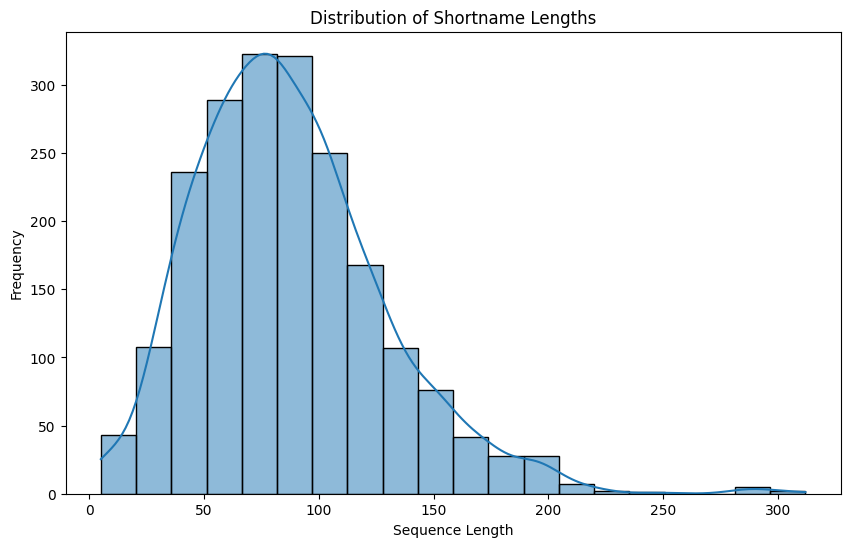

In [10]:
shortname_len = []
for i in range(len(unique_doc_list)):
    unique_doc_list[i]['tokenized_shortname'] = tokenizer(unique_doc_list[i]['shortname'], padding=False, return_tensors="pt")
    shortname_len.append(unique_doc_list[i]['tokenized_shortname'].input_ids.shape[1])
    
plt.figure(figsize=(10, 6))
sns.histplot(shortname_len, bins=20, kde=True)  # kde=True adds a kernel density estimate line
plt.title('Distribution of Shortname Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

### Create retriever

In [11]:
vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, sublinear_tf=True)
tfidf_matrix = vectorizer.fit_transform([preprocess(doc['law']) for doc in unique_doc_list])

In [12]:
corpus = [preprocess(doc['law']).split() for doc in unique_doc_list]
bm25 = BM25Okapi(corpus)

### Evaluate retriever

In [13]:
# For TFIDF

y_pred = []
y_truth = [dataset[i]['documents'] for i in range(len(dataset))]
for i in tqdm(range(len(dataset))):
    query = dataset[i]['question']
    query_vec = vectorizer.transform([preprocess(query)])
    cs = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_docs_indices = np.argsort(cs)[::-1]
    retrieved_docs = []
    for idx in top_docs_indices[:8]:
        retrieved_docs.append(unique_doc_list[idx])
    y_pred.append(retrieved_docs)
    
def inside(text, list_of_text):
    return any(text['name'] == t['name'] for t in list_of_text)

acc1, acc3, acc5 = 0, 0, 0
for i in range(len(y_truth)):
    if all(inside(gt, y_pred[i][:1]) for gt in y_truth[i]):
        acc1 += 1
    
    if all(inside(gt, y_pred[i][:3]) for gt in y_truth[i]):
        acc3 += 1
    
    if all(inside(gt, y_pred[i][:5]) for gt in y_truth[i]):
        acc5 += 1
        
acc1 /= len(y_truth)
acc3 /= len(y_truth)
acc5 /= len(y_truth)
print(acc1, acc3, acc5)

100%|██████████| 2345/2345 [00:18<00:00, 126.66it/s]

0.18422174840085287 0.3185501066098081 0.3927505330490405


In [14]:
# For BM25

y_pred = []
y_truth = [dataset[i]['documents'] for i in range(len(dataset))]

for i in tqdm(range(len(dataset))):
    query = preprocess(dataset[i]['question']).split()
    
    retrieved_docs = bm25.get_top_n(query, unique_doc_list, n=8)

    y_pred.append(retrieved_docs)
    
def inside(text, list_of_text):
    return any(text['name'] == t['name'] for t in list_of_text)

acc1, acc3, acc5 = 0, 0, 0
for i in range(len(y_truth)):
    if all(inside(gt, y_pred[i][:1]) for gt in y_truth[i]):
        acc1 += 1
    
    if all(inside(gt, y_pred[i][:3]) for gt in y_truth[i]):
        acc3 += 1
    
    if all(inside(gt, y_pred[i][:5]) for gt in y_truth[i]):
        acc5 += 1
        
acc1 /= len(y_truth)
acc3 /= len(y_truth)
acc5 /= len(y_truth)
print(acc1, acc3, acc5)

100%|██████████| 2345/2345 [00:41<00:00, 56.87it/s] 

0.22217484008528784 0.36673773987206826 0.42388059701492536


### Testing

In [15]:
query = 'Sinh viên có sổ hộ nghèo được hỗ trợ như thế nào về học phí?'
query_vec = vectorizer.transform([preprocess(query)])
    
cs = cosine_similarity(query_vec, tfidf_matrix).flatten()
top_docs_indices = np.argsort(cs)[::-1]

retrieved_docs = []
for idx in top_docs_indices[:5]:
    retrieved_docs.append(unique_doc_list[idx])

print(*['TRẢ LỜI: ' + doc['name'] + '\n' + doc['law'] for doc in retrieved_docs], sep='\n\n')

TRẢ LỜI: Tại khoản 4 Điều 12 Luật bảo hiểm y tế 2008 được sửa đổi bởi khoản 6 Điều 1 Luật Bảo hiểm y tế sửa đổi 2014 quy định đối tượng tham gia bảo hiểm y tế như sau:
4. Nhóm được ngân sách nhà nước hỗ trợ mức đóng, bao gồm:
a) Người thuộc hộ gia đình cận nghèo;
b) Học sinh, sinh viên.

TRẢ LỜI: Căn cứ Điều 4 Nghị định 146/2018/NĐ-CP quy định nhóm được ngân sách nhà nước hỗ trợ mức đóng, cụ thể như sau:
1. Người thuộc hộ gia đình cận nghèo theo tiêu chí chuẩn cận nghèo theo quy định của Chính phủ, Thủ tướng Chính phủ.
2. Người thuộc hộ gia đình nghèo đa chiều không thuộc trường hợp quy định tại điểm a khoản 9 Điều 3 Nghị định này.
3. Học sinh, sinh viên.
4. Người thuộc hộ gia đình làm nông nghiệp, lâm nghiệp, ngư nghiệp và diêm nghiệp có mức sống trung bình theo quy định của Chính phủ, Thủ tướng Chính phủ.

TRẢ LỜI: Tại Khoản 12 Điều 15 Nghị định 81/2021/NĐ-CP (Có hiệu lực từ 15/10/2021), có quy định:
Điều 15. Đối tượng được miễn học phí
12. Học sinh, sinh viên học tại các cơ sở giáo 